<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_AFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [21]:
Q=2000
alpha=0.1
sigma=0.6
mu=0.016
tau=1e-4
c=.6
true_params = np.array((Q, alpha,sigma,mu,tau,c))
def AFB(y,t,ps):
    try:
        Q = ps['Q'].value
        alpha = ps['alpha'].value
        sigma = ps['sigma'].value
        mu = ps['mu'].value
        tau = ps['tau'].value
        c = ps['c'].value
    except:
        Q,alpha,sigma,mu,tau,c = ps
    L_s,L_i,B=y
    L_s_p=Q*(L_s+B)/(L_i+L_s+B)-L_s*(alpha-sigma*(B/(L_i+L_s+B)))-L_s*B*tau*(L_i/(L_i+L_s))
    L_i_p=L_s*B*tau*(L_i/(L_i+L_s))-c*L_i*(B/(L_i+L_s+B))
    B_p=L_s*(alpha-sigma*(B/(L_i+L_s+B)))-mu*B
    if(L_i==0):
        L_i_p=0
    return np.array([L_s_p,L_i_p,B_p])
L_s_fijo=(1/(2*alpha))*((Q/mu)*((-alpha+sigma+mu)+np.sqrt((alpha-sigma-mu)**2+4*alpha*mu)))
L_i_fijo=0
B_fijo=Q/mu

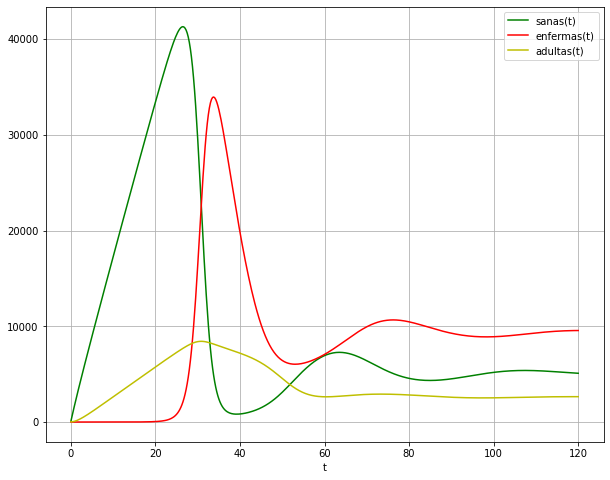

In [56]:
y0 = [100,1,20]
plt.figure(figsize=(10, 8))
INPUT = (y0[0],y0[1],y0[2])
t = np.linspace(0, 120, 481)
from scipy.integrate import odeint
sol = odeint(AFB, y0, t, args=([Q,alpha,sigma,mu,tau,c],))
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'g', label='sanas(t)')
plt.plot(t, sol[:, 1], 'r', label='enfermas(t)')
plt.plot(t, sol[:, 2], 'y', label='adultas(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [25]:
from scipy import stats

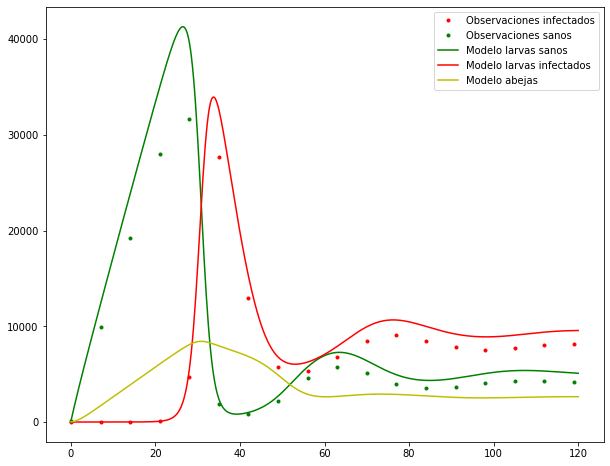

In [55]:
frecuancia_muestra=np.arange(0,len(t),28)
datos_larvas_infectados=np.array([stats.binom.rvs(n=int(sol[i,1]),p=0.85) for i in range(len(t))])[frecuancia_muestra]
datos_larvas_sanas=np.array([stats.binom.rvs(n=int(sol[i,0]),p=0.80) for i in range(len(t))])[frecuancia_muestra]
data=np.array([datos_larvas_sanas,datos_larvas_infectados]).T
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/4,datos_larvas_infectados,'r.',label='Observaciones infectados')
plt.plot(frecuancia_muestra/4,datos_larvas_sanas,'g.',label='Observaciones sanos')
plt.plot(np.arange(0,120.25,0.25),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,120.25,0.25),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,120.25,0.25),sol[:,2],'y',label='Modelo abejas')
plt.legend()


In [36]:
#!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 16.0 MB/s 
     |████████████████████████████████| 98 kB 7.5 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=3ff65df6db82b43efda2a63683e5da73970ffb82f61598d33a00a74a6886560f
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [37]:
def g(t,INP,ps):
    SOL = odeint(AFB,INPUT,t,args=(ps,))
    return SOL[:,0:2]

In [38]:
def g_B(t,INP,ps):
    SOL = odeint(AFB,INPUT,t,args=(ps,))
    return SOL[:,2]

In [42]:
def residual(ps,ts,data):
    INP = ps['L_S_0'].value, ps['L_I_0'].value, ps['B'].value
    model = g(ts,INP,ps)
    return (model[frecuancia_muestra]-data).ravel()

In [44]:
from lmfit import minimize, Parameters, Parameter, report_fit
params = Parameters()
params.add('Q', value=1000, min=500, max=3000)
params.add('alpha', value=0.2, min=0, max=0.5)
params.add('sigma', value=0.55, min=0.5, max=1)#Se puede incluir la restriccion alpha<sigma?
params.add('mu', value=0.000001, min=0, max=0.5)
params.add('tau', value=0.000001, min=0, max=0.5)
params.add('c', value=0.5, min=0, max=1)
params.add('L_S_0', value=float(3), min=3, max=4)
params.add('L_I_0', value= float(1), min=1, max=2)
params.add('B', value=float(50), min=50, max=51)

In [45]:
result = minimize(residual, params, args=(t, data), method='leastsq',)

final = data + result.residual.reshape(data.shape)
result

In [ ]:
print(true_params)

[1.4e+01 2.0e-01 7.0e-01 1.0e-04 2.5e-04 1.0e-01]


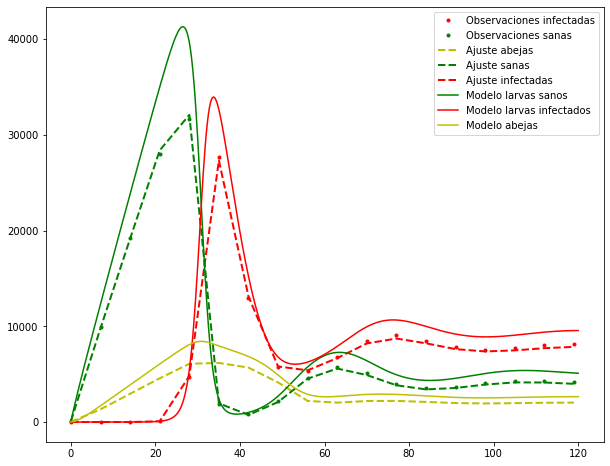

In [57]:
# plot data and fitted curves
plt.figure(figsize=(10, 8))
plt.plot(frecuancia_muestra/4,data[:,1], '.r',label='Observaciones infectadas')
plt.plot(frecuancia_muestra/4,data[:,0], '.g',label='Observaciones sanas')

plt.plot(frecuancia_muestra/4,g_B(t,INPUT,result.params)[frecuancia_muestra], '--y', linewidth=2,label='Ajuste abejas');
plt.plot(frecuancia_muestra/4,g(t,INPUT,result.params)[:,0][frecuancia_muestra], '--g', linewidth=2,label='Ajuste sanas');
plt.plot(frecuancia_muestra/4,g(t,INPUT,result.params)[:,1][frecuancia_muestra], '--r', linewidth=2,label='Ajuste infectadas');
plt.plot(np.arange(0,120.25,0.25),sol[:,0],'g',label='Modelo larvas sanos')
plt.plot(np.arange(0,120.25,0.25),sol[:,1],'r',label='Modelo larvas infectados')
plt.plot(np.arange(0,120.25,0.25),sol[:,2],'y',label='Modelo abejas')
plt.legend()